In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_excel(r"C:\Users\HP Laptops\Downloads\default of credit card clients.xls")

In [3]:
df.shape

(30000, 25)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df=df.drop('ID',axis=1)

In [6]:
df.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [7]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
df.iloc[:,0:24]=scaler.fit_transform(df.iloc[:,0:24])

In [9]:
# Determining 10 best features
X = df.iloc[:,0:24]  
y = df.iloc[:,-1]    
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  

                         Specs         Score
23  default payment next month  23364.000000
5                        PAY_0    201.517549
6                        PAY_2    160.027300
7                        PAY_3    129.692706
8                        PAY_4    108.131709
9                        PAY_5     92.598810
10                       PAY_6     81.065996
0                    LIMIT_BAL     76.341829
1                          SEX     18.983326
21                    PAY_AMT5     10.394332


[3.36186739e-03 6.07834340e-04 1.02938881e-03 6.40675651e-04
 1.12294940e-03 2.18505389e-02 1.19950522e-02 1.06487067e-02
 7.83977259e-03 1.04015958e-02 4.54545365e-03 1.10140373e-03
 1.03689205e-03 9.49986988e-04 8.87051013e-04 9.37679008e-04
 9.20499989e-04 1.18475484e-03 1.05116657e-03 9.66855988e-04
 8.25759025e-04 1.01937366e-03 8.37781558e-04 9.14236960e-01]


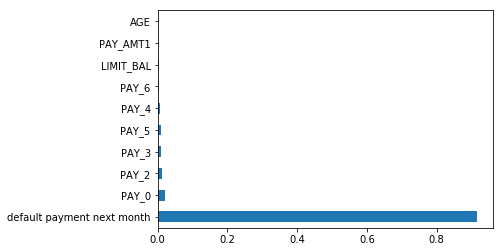

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [11]:
df1=df[['AGE','PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','LIMIT_BAL', 'SEX','default payment next month']]

In [12]:
np.random.seed(0)
df_train,df_test=train_test_split(df1, train_size=0.7,test_size=0.3, random_state = 100)

In [13]:
y_train = df_train.pop('default payment next month')
X_train = df_train
y_test = df_test.pop('default payment next month')
X_test = df_test

In [14]:
# fit model no training data
model = XGBClassifier(max_depth=20,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=1200,
                        learning_rate = 0.0001)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
model.fit(X_train, y_train)

[0]	validation_0-error:0.178952	validation_0-logloss:0.693185	validation_1-error:0.208333	validation_1-logloss:0.693075
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.170381	validation_0-logloss:0.693164	validation_1-error:0.193111	validation_1-logloss:0.693033
[2]	validation_0-error:0.16781	validation_0-logloss:0.693144	validation_1-error:0.191222	validation_1-logloss:0.692991
[3]	validation_0-error:0.165476	validation_0-logloss:0.692903	validation_1-error:0.187222	validation_1-logloss:0.692975
[4]	validation_0-error:0.16481	validation_0-logloss:0.692842	validation_1-error:0.186667	validation_1-logloss:0.692945
[5]	validation_0-error:0.16381	validation_0-logloss:0.692807	validation_1-error:0.185778	validation_1-logloss:0.692907
[6]	validation_0-error:0.163762	validation_0-logloss:0.692742	validation_1-error:0.186	validation_1-logloss:0.692837
[

[67]	validation_0-error:0.163095	validation_0-logloss:0.689965	validation_1-error:0.184	validation_1-logloss:0.690142
[68]	validation_0-error:0.162905	validation_0-logloss:0.689921	validation_1-error:0.183778	validation_1-logloss:0.690096
[69]	validation_0-error:0.162714	validation_0-logloss:0.689871	validation_1-error:0.184444	validation_1-logloss:0.690043
[70]	validation_0-error:0.162905	validation_0-logloss:0.689825	validation_1-error:0.184667	validation_1-logloss:0.689999
[71]	validation_0-error:0.162952	validation_0-logloss:0.689771	validation_1-error:0.184333	validation_1-logloss:0.689961
[72]	validation_0-error:0.163095	validation_0-logloss:0.689695	validation_1-error:0.184444	validation_1-logloss:0.689925
[73]	validation_0-error:0.162857	validation_0-logloss:0.689642	validation_1-error:0.184444	validation_1-logloss:0.689882
[74]	validation_0-error:0.162905	validation_0-logloss:0.689595	validation_1-error:0.184333	validation_1-logloss:0.68983
[75]	validation_0-error:0.163143	val

[135]	validation_0-error:0.163048	validation_0-logloss:0.686795	validation_1-error:0.182778	validation_1-logloss:0.68716
[136]	validation_0-error:0.163238	validation_0-logloss:0.686761	validation_1-error:0.182889	validation_1-logloss:0.687122
[137]	validation_0-error:0.163286	validation_0-logloss:0.686717	validation_1-error:0.182889	validation_1-logloss:0.687084
[138]	validation_0-error:0.163476	validation_0-logloss:0.686663	validation_1-error:0.183	validation_1-logloss:0.687037
[139]	validation_0-error:0.163429	validation_0-logloss:0.686616	validation_1-error:0.182778	validation_1-logloss:0.686987
[140]	validation_0-error:0.163381	validation_0-logloss:0.686576	validation_1-error:0.182889	validation_1-logloss:0.686941
[141]	validation_0-error:0.163476	validation_0-logloss:0.686506	validation_1-error:0.182889	validation_1-logloss:0.6869
[142]	validation_0-error:0.163381	validation_0-logloss:0.686448	validation_1-error:0.182667	validation_1-logloss:0.68686
[143]	validation_0-error:0.1632

[203]	validation_0-error:0.163143	validation_0-logloss:0.683647	validation_1-error:0.183	validation_1-logloss:0.684219
[204]	validation_0-error:0.163048	validation_0-logloss:0.683603	validation_1-error:0.182889	validation_1-logloss:0.684177
[205]	validation_0-error:0.163048	validation_0-logloss:0.683562	validation_1-error:0.183	validation_1-logloss:0.684136
[206]	validation_0-error:0.163	validation_0-logloss:0.683525	validation_1-error:0.183222	validation_1-logloss:0.684098
[207]	validation_0-error:0.163095	validation_0-logloss:0.683487	validation_1-error:0.183111	validation_1-logloss:0.684055
[208]	validation_0-error:0.163095	validation_0-logloss:0.683444	validation_1-error:0.183111	validation_1-logloss:0.684009
[209]	validation_0-error:0.163048	validation_0-logloss:0.683408	validation_1-error:0.183	validation_1-logloss:0.683965
[210]	validation_0-error:0.163095	validation_0-logloss:0.683368	validation_1-error:0.183	validation_1-logloss:0.683921
[211]	validation_0-error:0.16319	valida

[271]	validation_0-error:0.162952	validation_0-logloss:0.680582	validation_1-error:0.183778	validation_1-logloss:0.681329
[272]	validation_0-error:0.162952	validation_0-logloss:0.680533	validation_1-error:0.183667	validation_1-logloss:0.681288
[273]	validation_0-error:0.163095	validation_0-logloss:0.680486	validation_1-error:0.183556	validation_1-logloss:0.681247
[274]	validation_0-error:0.163143	validation_0-logloss:0.680435	validation_1-error:0.183667	validation_1-logloss:0.681204
[275]	validation_0-error:0.163048	validation_0-logloss:0.680391	validation_1-error:0.183667	validation_1-logloss:0.681162
[276]	validation_0-error:0.162952	validation_0-logloss:0.680347	validation_1-error:0.183667	validation_1-logloss:0.681121
[277]	validation_0-error:0.162857	validation_0-logloss:0.680311	validation_1-error:0.183667	validation_1-logloss:0.681082
[278]	validation_0-error:0.162905	validation_0-logloss:0.680272	validation_1-error:0.183667	validation_1-logloss:0.681041
[279]	validation_0-error

[339]	validation_0-error:0.162905	validation_0-logloss:0.677552	validation_1-error:0.183667	validation_1-logloss:0.678484
[340]	validation_0-error:0.163	validation_0-logloss:0.677503	validation_1-error:0.183556	validation_1-logloss:0.67844
[341]	validation_0-error:0.163048	validation_0-logloss:0.677464	validation_1-error:0.183778	validation_1-logloss:0.678397
[342]	validation_0-error:0.163048	validation_0-logloss:0.677421	validation_1-error:0.183556	validation_1-logloss:0.678353
[343]	validation_0-error:0.163143	validation_0-logloss:0.677362	validation_1-error:0.183667	validation_1-logloss:0.678316
[344]	validation_0-error:0.163	validation_0-logloss:0.677314	validation_1-error:0.183667	validation_1-logloss:0.678276
[345]	validation_0-error:0.163048	validation_0-logloss:0.677268	validation_1-error:0.183556	validation_1-logloss:0.678234
[346]	validation_0-error:0.163095	validation_0-logloss:0.677221	validation_1-error:0.183778	validation_1-logloss:0.67819
[347]	validation_0-error:0.16309

[407]	validation_0-error:0.162857	validation_0-logloss:0.674531	validation_1-error:0.183556	validation_1-logloss:0.675659
[408]	validation_0-error:0.16281	validation_0-logloss:0.674489	validation_1-error:0.183444	validation_1-logloss:0.675619
[409]	validation_0-error:0.162905	validation_0-logloss:0.674446	validation_1-error:0.183333	validation_1-logloss:0.675578
[410]	validation_0-error:0.16281	validation_0-logloss:0.674407	validation_1-error:0.183333	validation_1-logloss:0.675537
[411]	validation_0-error:0.162714	validation_0-logloss:0.674367	validation_1-error:0.183444	validation_1-logloss:0.675496
[412]	validation_0-error:0.162857	validation_0-logloss:0.674322	validation_1-error:0.183444	validation_1-logloss:0.675455
[413]	validation_0-error:0.162857	validation_0-logloss:0.674275	validation_1-error:0.183333	validation_1-logloss:0.675413
[414]	validation_0-error:0.162905	validation_0-logloss:0.674233	validation_1-error:0.183333	validation_1-logloss:0.675372
[415]	validation_0-error:0

[475]	validation_0-error:0.163048	validation_0-logloss:0.671567	validation_1-error:0.183556	validation_1-logloss:0.672877
[476]	validation_0-error:0.163095	validation_0-logloss:0.671527	validation_1-error:0.183778	validation_1-logloss:0.672835
[477]	validation_0-error:0.163048	validation_0-logloss:0.671477	validation_1-error:0.183778	validation_1-logloss:0.672797
[478]	validation_0-error:0.16319	validation_0-logloss:0.671433	validation_1-error:0.183667	validation_1-logloss:0.672759
[479]	validation_0-error:0.163286	validation_0-logloss:0.671389	validation_1-error:0.183889	validation_1-logloss:0.672719
[480]	validation_0-error:0.16319	validation_0-logloss:0.671346	validation_1-error:0.183889	validation_1-logloss:0.672675
[481]	validation_0-error:0.163286	validation_0-logloss:0.671301	validation_1-error:0.183778	validation_1-logloss:0.672634
[482]	validation_0-error:0.163238	validation_0-logloss:0.671259	validation_1-error:0.184	validation_1-logloss:0.672593
[483]	validation_0-error:0.16

[543]	validation_0-error:0.163238	validation_0-logloss:0.668638	validation_1-error:0.184	validation_1-logloss:0.670146
[544]	validation_0-error:0.163143	validation_0-logloss:0.668597	validation_1-error:0.184	validation_1-logloss:0.670105
[545]	validation_0-error:0.163286	validation_0-logloss:0.668556	validation_1-error:0.184111	validation_1-logloss:0.670067
[546]	validation_0-error:0.163238	validation_0-logloss:0.668516	validation_1-error:0.184	validation_1-logloss:0.670029
[547]	validation_0-error:0.16319	validation_0-logloss:0.668475	validation_1-error:0.184111	validation_1-logloss:0.669989
[548]	validation_0-error:0.163333	validation_0-logloss:0.668435	validation_1-error:0.184	validation_1-logloss:0.669951
[549]	validation_0-error:0.16319	validation_0-logloss:0.668394	validation_1-error:0.184	validation_1-logloss:0.669909
[550]	validation_0-error:0.163238	validation_0-logloss:0.668356	validation_1-error:0.183778	validation_1-logloss:0.669868
[551]	validation_0-error:0.16319	validati

[611]	validation_0-error:0.163048	validation_0-logloss:0.665758	validation_1-error:0.183889	validation_1-logloss:0.667444
[612]	validation_0-error:0.163048	validation_0-logloss:0.665717	validation_1-error:0.183889	validation_1-logloss:0.667405
[613]	validation_0-error:0.163	validation_0-logloss:0.665678	validation_1-error:0.183778	validation_1-logloss:0.667366
[614]	validation_0-error:0.163048	validation_0-logloss:0.665633	validation_1-error:0.183667	validation_1-logloss:0.667326
[615]	validation_0-error:0.163048	validation_0-logloss:0.66559	validation_1-error:0.183667	validation_1-logloss:0.667288
[616]	validation_0-error:0.163095	validation_0-logloss:0.665542	validation_1-error:0.183667	validation_1-logloss:0.667247
[617]	validation_0-error:0.163	validation_0-logloss:0.665496	validation_1-error:0.183667	validation_1-logloss:0.667207
[618]	validation_0-error:0.163	validation_0-logloss:0.665453	validation_1-error:0.183667	validation_1-logloss:0.667168
[619]	validation_0-error:0.163	val

[680]	validation_0-error:0.163048	validation_0-logloss:0.66285	validation_1-error:0.184111	validation_1-logloss:0.66474
[681]	validation_0-error:0.163095	validation_0-logloss:0.662809	validation_1-error:0.184222	validation_1-logloss:0.6647
[682]	validation_0-error:0.163095	validation_0-logloss:0.662767	validation_1-error:0.184222	validation_1-logloss:0.664661
[683]	validation_0-error:0.163143	validation_0-logloss:0.662725	validation_1-error:0.184222	validation_1-logloss:0.664618
[684]	validation_0-error:0.16319	validation_0-logloss:0.662686	validation_1-error:0.184222	validation_1-logloss:0.664583
[685]	validation_0-error:0.16319	validation_0-logloss:0.66265	validation_1-error:0.184222	validation_1-logloss:0.664544
[686]	validation_0-error:0.16319	validation_0-logloss:0.662613	validation_1-error:0.184111	validation_1-logloss:0.664507
[687]	validation_0-error:0.163095	validation_0-logloss:0.662572	validation_1-error:0.184222	validation_1-logloss:0.664468
[688]	validation_0-error:0.16314

[748]	validation_0-error:0.16281	validation_0-logloss:0.660027	validation_1-error:0.184111	validation_1-logloss:0.662102
[749]	validation_0-error:0.16281	validation_0-logloss:0.659991	validation_1-error:0.184222	validation_1-logloss:0.662063
[750]	validation_0-error:0.162857	validation_0-logloss:0.659952	validation_1-error:0.184222	validation_1-logloss:0.662024
[751]	validation_0-error:0.162762	validation_0-logloss:0.659911	validation_1-error:0.184222	validation_1-logloss:0.661984
[752]	validation_0-error:0.162762	validation_0-logloss:0.659872	validation_1-error:0.184111	validation_1-logloss:0.661948
[753]	validation_0-error:0.162762	validation_0-logloss:0.659832	validation_1-error:0.184	validation_1-logloss:0.66191
[754]	validation_0-error:0.162857	validation_0-logloss:0.659787	validation_1-error:0.184	validation_1-logloss:0.661871
[755]	validation_0-error:0.162905	validation_0-logloss:0.659744	validation_1-error:0.184	validation_1-logloss:0.661832
[756]	validation_0-error:0.162905	va

[816]	validation_0-error:0.162762	validation_0-logloss:0.657246	validation_1-error:0.184111	validation_1-logloss:0.659507
[817]	validation_0-error:0.162762	validation_0-logloss:0.657209	validation_1-error:0.184111	validation_1-logloss:0.659467
[818]	validation_0-error:0.162762	validation_0-logloss:0.65717	validation_1-error:0.184111	validation_1-logloss:0.659427
[819]	validation_0-error:0.162762	validation_0-logloss:0.657123	validation_1-error:0.184111	validation_1-logloss:0.659388
[820]	validation_0-error:0.162762	validation_0-logloss:0.657082	validation_1-error:0.184	validation_1-logloss:0.659352
[821]	validation_0-error:0.162762	validation_0-logloss:0.657041	validation_1-error:0.184	validation_1-logloss:0.659313
[822]	validation_0-error:0.16281	validation_0-logloss:0.657	validation_1-error:0.184111	validation_1-logloss:0.659276
[823]	validation_0-error:0.16281	validation_0-logloss:0.656958	validation_1-error:0.184	validation_1-logloss:0.65924
[824]	validation_0-error:0.16281	validat

[885]	validation_0-error:0.162857	validation_0-logloss:0.654453	validation_1-error:0.183778	validation_1-logloss:0.656901
[886]	validation_0-error:0.162857	validation_0-logloss:0.654414	validation_1-error:0.183778	validation_1-logloss:0.656863
[887]	validation_0-error:0.162857	validation_0-logloss:0.65437	validation_1-error:0.183778	validation_1-logloss:0.656829
[888]	validation_0-error:0.16281	validation_0-logloss:0.654329	validation_1-error:0.183778	validation_1-logloss:0.656789
[889]	validation_0-error:0.162857	validation_0-logloss:0.65429	validation_1-error:0.183778	validation_1-logloss:0.656751
[890]	validation_0-error:0.162905	validation_0-logloss:0.654246	validation_1-error:0.183778	validation_1-logloss:0.656713
[891]	validation_0-error:0.162952	validation_0-logloss:0.654206	validation_1-error:0.183778	validation_1-logloss:0.656675
[892]	validation_0-error:0.162905	validation_0-logloss:0.654169	validation_1-error:0.183778	validation_1-logloss:0.65664
[893]	validation_0-error:0.1

[953]	validation_0-error:0.162857	validation_0-logloss:0.65173	validation_1-error:0.183889	validation_1-logloss:0.654374
[954]	validation_0-error:0.162905	validation_0-logloss:0.65169	validation_1-error:0.183778	validation_1-logloss:0.654338
[955]	validation_0-error:0.162952	validation_0-logloss:0.651651	validation_1-error:0.183778	validation_1-logloss:0.654301
[956]	validation_0-error:0.162905	validation_0-logloss:0.651608	validation_1-error:0.183778	validation_1-logloss:0.654262
[957]	validation_0-error:0.162905	validation_0-logloss:0.651568	validation_1-error:0.183778	validation_1-logloss:0.654226
[958]	validation_0-error:0.163	validation_0-logloss:0.651529	validation_1-error:0.183889	validation_1-logloss:0.654189
[959]	validation_0-error:0.162952	validation_0-logloss:0.651494	validation_1-error:0.183778	validation_1-logloss:0.654153
[960]	validation_0-error:0.163	validation_0-logloss:0.651454	validation_1-error:0.183778	validation_1-logloss:0.654114
[961]	validation_0-error:0.163	v

[1021]	validation_0-error:0.163143	validation_0-logloss:0.649047	validation_1-error:0.183889	validation_1-logloss:0.651875
[1022]	validation_0-error:0.163143	validation_0-logloss:0.649005	validation_1-error:0.183889	validation_1-logloss:0.651836
[1023]	validation_0-error:0.163143	validation_0-logloss:0.648966	validation_1-error:0.183778	validation_1-logloss:0.6518
[1024]	validation_0-error:0.163143	validation_0-logloss:0.648923	validation_1-error:0.183778	validation_1-logloss:0.651762
[1025]	validation_0-error:0.163143	validation_0-logloss:0.648881	validation_1-error:0.183889	validation_1-logloss:0.651726
[1026]	validation_0-error:0.163143	validation_0-logloss:0.648845	validation_1-error:0.183889	validation_1-logloss:0.65169
[1027]	validation_0-error:0.16319	validation_0-logloss:0.648805	validation_1-error:0.183889	validation_1-logloss:0.651653
[1028]	validation_0-error:0.163143	validation_0-logloss:0.648769	validation_1-error:0.183889	validation_1-logloss:0.651619
[1029]	validation_0-

[1089]	validation_0-error:0.163143	validation_0-logloss:0.646394	validation_1-error:0.184	validation_1-logloss:0.649411
[1090]	validation_0-error:0.16319	validation_0-logloss:0.646356	validation_1-error:0.184	validation_1-logloss:0.649374
[1091]	validation_0-error:0.16319	validation_0-logloss:0.646318	validation_1-error:0.184	validation_1-logloss:0.649337
[1092]	validation_0-error:0.163143	validation_0-logloss:0.646278	validation_1-error:0.184	validation_1-logloss:0.649302
[1093]	validation_0-error:0.16319	validation_0-logloss:0.64624	validation_1-error:0.184	validation_1-logloss:0.649268
[1094]	validation_0-error:0.16319	validation_0-logloss:0.646204	validation_1-error:0.184	validation_1-logloss:0.649231
[1095]	validation_0-error:0.16319	validation_0-logloss:0.646165	validation_1-error:0.183778	validation_1-logloss:0.649194
[1096]	validation_0-error:0.163143	validation_0-logloss:0.646128	validation_1-error:0.183778	validation_1-logloss:0.649159
[1097]	validation_0-error:0.163143	valid

[1156]	validation_0-error:0.163333	validation_0-logloss:0.643813	validation_1-error:0.183778	validation_1-logloss:0.647015
[1157]	validation_0-error:0.163333	validation_0-logloss:0.643777	validation_1-error:0.183778	validation_1-logloss:0.646978
[1158]	validation_0-error:0.163381	validation_0-logloss:0.643738	validation_1-error:0.183778	validation_1-logloss:0.646941
[1159]	validation_0-error:0.163381	validation_0-logloss:0.643698	validation_1-error:0.183778	validation_1-logloss:0.646906
[1160]	validation_0-error:0.163381	validation_0-logloss:0.643662	validation_1-error:0.183778	validation_1-logloss:0.64687
[1161]	validation_0-error:0.163286	validation_0-logloss:0.643622	validation_1-error:0.183778	validation_1-logloss:0.646837
[1162]	validation_0-error:0.163286	validation_0-logloss:0.643585	validation_1-error:0.183667	validation_1-logloss:0.646801
[1163]	validation_0-error:0.163333	validation_0-logloss:0.643548	validation_1-error:0.183778	validation_1-logloss:0.646766
[1164]	validation

XGBClassifier(learning_rate=0.0001, max_depth=20, n_estimators=1200,
              subsample=0.33)

In [18]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [20]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.64%


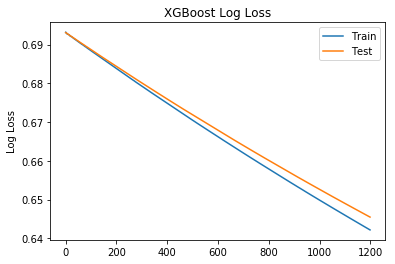

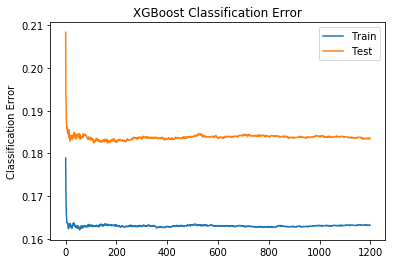

In [21]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()